In [1]:
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import metrics
from math import cos, asin, sqrt, pi
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import re
import sys
import seaborn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn import model_selection, preprocessing, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy import sparse
from sklearn.metrics import log_loss
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

sns.set_style('darkgrid')

%matplotlib inline

In [2]:
d = None  
data = None  
with zipfile.ZipFile("train.json.zip", "r") as z:
   for filename in z.namelist():    
      with z.open(filename) as f:  
         data = f.read()  
         d = json.loads(data.decode("utf-8"))
        
train = pd.DataFrame.from_dict(d)

d = None  
data = None  
with zipfile.ZipFile("test.json.zip", "r") as z:
   for filename in z.namelist():    
      with z.open(filename) as f:  
         data = f.read()  
         d = json.loads(data.decode("utf-8"))
        
test_data = pd.DataFrame.from_dict(d)
listing_id = test_data['listing_id']

price_front_percentile = np.percentile(train.price, 1)
price_end_percentile = np.percentile(train.price, 99)
train = train[(train['price'] < np.int(price_end_percentile)) & (train['price'] > np.int(price_front_percentile))]

latitude_front_percentile = np.percentile(train.latitude, 1)
latitude_end_percentile = np.percentile(train.latitude, 99)
train = train[(train['latitude'] < np.float(latitude_end_percentile)) & (train['latitude'] > np.float(latitude_front_percentile))]


longitude_front_percentile = np.percentile(train.longitude, 1)
longitude_end_percentile = np.percentile(train.longitude, 99)
train = train[(train['longitude'] < np.float(longitude_end_percentile)) & (train['longitude'] > np.float(longitude_front_percentile))]

# Get X and y(label)
train_data = train.copy()
train_data["interest_level"] = train_data["interest_level"].apply(lambda x: 0 if x=="low" else 1 if x=="medium" else 2)
y = train_data['interest_level']
del train_data['interest_level']
X = train_data.copy()


In [3]:
# # Get the training data
# train_data = pd.read_csv('train.csv').copy()
# train_data = train_data.drop(columns=['Unnamed: 0'])

# # Let num_photos in the end of df so that match testing data
# num_photos = train_data['num_photos']
# train_data = train_data.drop(columns=['num_photos'])
# train_data['num_photos'] = num_photos

# # Get X and y(label)
# y = train_data['interest_level']
# del train_data['interest_level']
# del train_data['distance']
# X = train_data.copy()

# # Get the testing data
# test_data = pd.read_csv('test.csv')
# test_data = test_data.drop(columns=['Unnamed: 0'])



In [4]:
# Feature enginering
# Add more features to help prediction 
# part of function are from teammates 
def computeCoordinateX(lat, lon):
    return np.cos(lat) * np.cos(lon)
getx = np.vectorize(computeCoordinateX)
def computeCoordinateY(lat, lon):
    return np.cos(lat) * np.sin(lon)
gety = np.vectorize(computeCoordinateY)
def getPriceOverRooms(price, bathroom, bedroom):
    return price / (1 + bedroom + bathroom)
getRatio = np.vectorize(getPriceOverRooms)

subway = pd.read_csv("subway.csv")
def distance_for_twopoints(lat1, lon1, lat2, lon2):
    p = pi/180     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a)) #2*R*asin...
vec_distance_for_two = np.vectorize(distance_for_twopoints)
def distance(location):
    distance = vec_distance_for_two(location[0],location[1],subway['Station Latitude'],subway['Station Longitude']);
    min_dis = min(distance)
    return min_dis

def feature_enginering(df , dfName):
    #transform lat and lon
    df['Coor_X'] = getx(df['latitude'], df['longitude'])
    df['Coor_Y'] = gety(df['latitude'], df['longitude'])
    #compute price over rooms (less the better)
    df['PriceOverRooms'] = getRatio(df['price'], df['bathrooms'], df['bedrooms'])
    
    df["num_photos"] = df["photos"].apply(len)
    
    df["num_features"] = df["features"].apply(len)
    
    df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
    
    df["num_furniture"] =  df["bathrooms"] + df["bedrooms"] 
    
    df["created"] = pd.to_datetime(df["created"])
    
    df["created_year"] = df["created"].dt.year
    
    df["created_month"] = df["created"].dt.month
    
    df["created_day"] = df["created"].dt.day
    
    df["created_hour"] = df["created"].dt.hour
    
    df["total_days"] = (df["created_month"] -4.0)*30 + df["created_day"] +  df["created_hour"] /25.0
    
    df["diff_rank"]= df["total_days"]/df["listing_id"]
    
    df["price_latitue"] = (df["price"])/ (df["latitude"]+1.0)
    
    df["price_longtitude"] = (df["price"])/ (df["longitude"]-1.0) 
    
    df['location'] = df[['latitude','longitude']].values.tolist()
#     df['distance'] = df['location'].apply(distance)
                        
#     for column in df.columns:
#         features_to_use.append(column)
    
#     for column in df.columns:
#         df[column] = df[column].astype(float)
    return df

X = feature_enginering(X, "train")
test_data = feature_enginering(test_data, "test")

features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                  "num_photos", "num_features", "num_description_words",
                   "created_month", "created_day", "created_hour" , "Coor_X" , "Coor_Y"
                  , "PriceOverRooms" , "num_furniture" , "total_days" ,"diff_rank" , "price_latitue",
                  "price_longtitude" , "created_year"]
        
print(features_to_use)
X

['bathrooms', 'bedrooms', 'latitude', 'longitude', 'price', 'num_photos', 'num_features', 'num_description_words', 'created_month', 'created_day', 'created_hour', 'Coor_X', 'Coor_Y', 'PriceOverRooms', 'num_furniture', 'total_days', 'diff_rank', 'price_latitue', 'price_longtitude', 'created_year']


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,Coor_X,Coor_Y,PriceOverRooms,num_photos,num_features,num_description_words,num_furniture,created_year,created_month,created_day,created_hour,total_days,diff_rank,price_latitue,price_longtitude,location
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,-0.125073,-0.983655,800.000000,12,7,77,2.0,2016,6,16,5,76.20,1.062713e-05,57.539055,-32.019681,"[40.7108, -73.9539]"
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,-0.143691,-0.985587,950.000000,6,6,131,3.0,2016,6,1,5,61.20,8.629023e-06,91.015130,-50.685454,"[40.7513, -73.9722]"
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,-0.134196,-0.987464,873.750000,6,6,119,3.0,2016,6,14,15,74.60,1.042092e-05,83.697539,-46.623312,"[40.7575, -73.9625]"
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,-0.113906,-0.985486,545.454545,5,0,95,4.5,2016,6,24,7,84.28,1.168736e-05,71.917439,-40.030690,"[40.7145, -73.9425]"
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,-0.145660,-0.984602,1397.500000,4,4,41,1.0,2016,6,28,3,88.12,1.219605e-05,66.955891,-37.279441,"[40.7439, -73.9743]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123998,1.0,0,0,2016-04-02 01:29:32,This studio apartment is located in Hell's Kit...,West 49th Street,"[Fireplace, Pre-War, Dogs Allowed, Cats Allowed]",40.7640,6812513,-73.9917,8b53ccf4338806ab1be3dd0267711649,[https://photos.renthop.com/2/6812513_ff385b2e...,2175,465 West 49th Street,-0.163054,-0.983637,1087.500000,1,4,59,1.0,2016,4,2,1,2.04,2.994490e-07,52.078345,-29.003210,"[40.764, -73.9917]"
124000,1.0,3,92bbbf38baadfde0576fc496bd41749c,2016-04-05 03:58:33,There is 700 square feet of recently renovated...,W 171 Street,"[Elevator, Dishwasher, Hardwood Floors]",40.8433,6824800,-73.9396,a61e21da3ba18c7a3d54cfdcc247e1f8,[https://photos.renthop.com/2/6824800_0682be16...,2800,620 W 171 Street,-0.111937,-0.993712,560.000000,5,3,131,4.0,2016,4,5,3,5.12,7.502051e-07,66.916328,-37.363423,"[40.8433, -73.9396]"
124002,1.0,2,5565db9b7cba3603834c4aa6f2950960,2016-04-02 02:25:31,"2 bedroom apartment with updated kitchen, rece...",Broadway,"[Common Outdoor Space, Cats Allowed, Dogs Allo...",40.8198,6813268,-73.9578,8f90e5e10e8a2d7cf997f016d89230eb,[https://photos.renthop.com/2/6813268_1e6fcc32...,2395,3333 Broadway,-0.129975,-0.991297,598.750000,5,7,70,3.0,2016,4,2,2,2.08,3.052867e-07,57.269523,-31.951311,"[40.8198, -73.9578]"
124008,1.0,2,3c0574a740154806c18bdf1fddd3d966,2016-04-19 02:47:33,Wonderful Bright Chelsea 2 Bedroom apartment o...,West 21st Street,"[Pre-War, Laundry in Unit, Dishwasher, No Fee,...",40.74

In [5]:
# ref: https://www.kaggle.com/sudalairajkumar/xgb-starter-in-python
categorical = ["display_address", "manager_id", "building_id", "street_address"]
for f in categorical:
        if X[f].dtype=='object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(X[f].values) + list(test_data[f].values))
            X[f] = lbl.transform(list(X[f].values))
            test_data[f] = lbl.transform(list(test_data[f].values))
            features_to_use.append(f)
            
X['features'] = X["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_data['features'] = test_data["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))

tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(X["features"])
te_sparse = tfidf.transform(test_data["features"])

X = sparse.hstack([X[features_to_use], tr_sparse]).tocsr()
test_data = sparse.hstack([test_data[features_to_use], te_sparse]).tocsr()

In [6]:
# XGB model setup 
# Build XGB model
def build_XGB(X_train, y_train, X_valid, num_round = 500):
    param = {'max_depth' : 6, 
             'booster' : 'gbtree',
             'objective' : 'multi:softprob',
             'bst:eta' : 0.04,
             'silent' : 1, 
             'gamma' : 1.0,
             'num_class' : 3, 
             'num_parallel_tree' : 3,
             'min_child_weight' : 1,
             'subsample' : 0.7 , 
             'lambda' : 5,
             'eval_metric' : "mlogloss",
             'colsample_bytree' : 0.7,
             'seed' : 0}
    
#     param = {}
#     param['objective'] = 'multi:softprob'
#     param['eta'] = 0.1
#     param['max_depth'] = 6
#     param['silent'] = 1
#     param['num_class'] = 3
#     param['eval_metric'] = "mlogloss"
#     param['min_child_weight'] = 1
#     param['subsample'] = 0.7
#     param['colsample_bytree'] = 0.7

#     param = list(param.items())
    
    xgb_train = xgb.DMatrix(X_train, label = y_train)
    xgb_valid = xgb.DMatrix(X_valid)
    xgb_model = xgb.train(param, xgb_train, num_round)
    
    predict_label = xgb_model.predict(xgb_valid)
    return predict_label, xgb_model

In [7]:
# ref: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
log_loss_scores = []
kf = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 2000)
for train_index, test_index in kf.split(range(X.shape[0])):
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    predict_label, xgb_model = build_XGB(X_train, y_train, X_test, 400)
    log_loss_scores.append(log_loss(y_test, predict_label))
    print(log_loss_scores)
    break

/Users/luduo/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0.5624320527446598]


In [8]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y)
# predict_label, xgb_model = build_XGB(X_train, y_train, X_train, 100)
# train_score = log_loss(y_train, predict_label)
# predict_label, xgb_model = build_XGB(X_valid, y_valid, X_valid, 100)
# valid_score = log_loss(y_valid, predict_label)

In [9]:
# print(" trainning vs. validation score (log-loss lower->better): ", train_score, valid_score)

In [10]:
predict_label, xgb_model = build_XGB(X, y, test_data , 400)
pred_df = pd.DataFrame(predict_label)
submit = {'high': pred_df.iloc[:,2], 'medium':pred_df.iloc[:,1], 'low':pred_df.iloc[:,0]}
submit = pd.DataFrame(submit)
listing_id = listing_id.to_frame()
listing_id = listing_id.reset_index(drop=True)
submit["listing_id"] = listing_id['listing_id']
submit.to_csv('submission.csv',index = False)
submission = pd.read_csv('submission.csv')
submission

/Users/luduo/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/luduo/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,high,medium,low,listing_id
0,0.028844,0.743692,0.227464,7142618
1,0.032134,0.025518,0.942348,7210040
2,0.000356,0.001468,0.998176,7174566
3,0.398622,0.338752,0.262626,7191391
4,0.006801,0.187461,0.805738,7171695
...,...,...,...,...
74654,0.817939,0.153859,0.028202,6928108
74655,0.009579,0.185435,0.804986,6906674
74656,0.000044,0.004099,0.995857,6897967
74657,0.000131,0.013350,0.986519,6842183


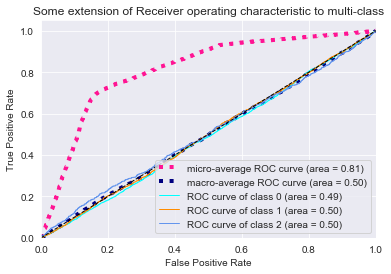

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
from sklearn import svm
# apply ROC metrics of decision tree
# cite: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html


y = label_binarize(y, classes=[0, 1, 2])

n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)
# model = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=10)
# # model = DecisionTreeClassifier(max_depth=10, min_samples_leaf = 10)
# # dt_model.fit(X_train, y_train)

predict_label, xgb_model = build_XGB(X_train, y_train, X_test, 100)
y_score = predict_label

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# # Plot of a ROC curve for a specific class
# plt.figure()
lw = 1
# plt.plot(fpr[2], tpr[2], color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()